#  Demo: lanczos and Loess operators applied to 1-d timeseries 

+ author  : Stephanie Leroux, IGE, MEOM
+ mail    : stephanie.leroux@univ-grenoble-alpes.fr
+ date    : Feb 2017
+ purpose : Simple example of how to use lanczos filtering and loess detrending on 1-d timeseries. 
+ -
+ *[Extra packages]*:  Extra packages to install: rpy2 (via conda) and pyclim () 

###  1. Define a LOESS detrending function `loess_detrend()` :

In [1]:
#import math
import numpy as np
#import numpy.fft as fft
#import numpy.ma as ma
#from scipy.stats import sem
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri
# Since rpy2 version 2.3, it is necessary to activate the automatic 
# conversion from numpy to R arrays
if hasattr(rpy2.robjects.numpy2ri, 'activate'):
   rpy2.robjects.numpy2ri.activate()

################################################
################################################
def loess_detrend(ts, time, wgts, span=0.99, degree=2):
    """ loess detrending inspired from Guillaume Serrazin's tools
        Uses R package for Python
        This loess filter is set for parameters (spann 0.99, degree=2) that
        are equivalent to a HP filter of cutoff period = half the total time-segment.
        
        Note: wgts is a vector containing the weights to apply on the operator for each time-step. T
        he normal usage is to set wgts to 0.   Ex:  wgts = np.ones(len(data) ). But sometimes you might
        need to impose that the first time step of the timeseries (data[0]) should be invariant through 
        the loess operator. In that case, just set the first weight to a high number. Ex: wgts[0]=1000.  
    """
    rloess = robjects.r['loess']
    fmla = robjects.Formula('y ~ x')
    env = fmla.environment
    env['x'] = time
    env['y'] = ts
    ts_dtr = np.array(rloess(fmla, span=span, degree=degree, weights=wgts)[2])
    return ts_dtr
 


### 2. Read some example data and plot:

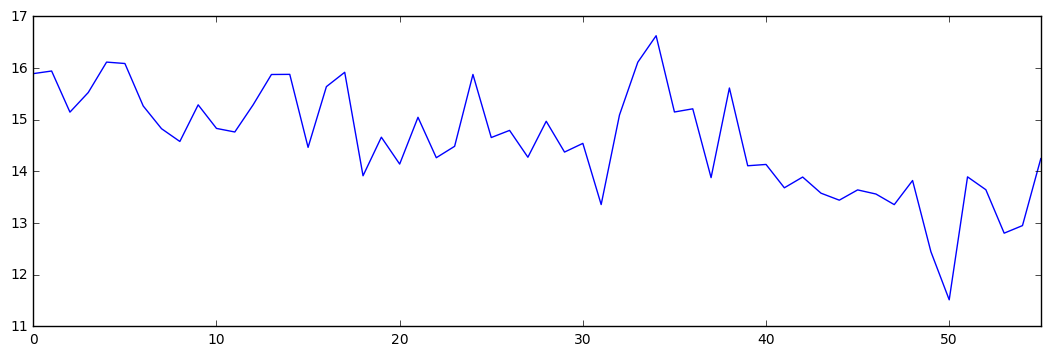

In [38]:
%matplotlib notebook
%matplotlib inline

import os, user, sys
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pickle
import numpy as np
import pyClim.filTools as filt


# Read df (which is a pandas dataframe)
diridat  = "/Users/leroux31/DATA/OCCIPUT_DATA/ORCA025.L75/MOC/"
fili     = 'MOCSIG.ORCA025.L75-OCCITENS.A.limsig35.5.lat25.9.pkl'
df       = pd.read_pickle(diridat+fili)

# Take the first column as a numpy vector and plot:
datats   = np.array(df["m01"])
datats

fig1 = plt.figure(figsize=([13,4]),facecolor='white')        
plt.plot(datats)
plt.xlim(0,datats_dt.shape[0]-1)
plt.show()   


### 3. Apply the Loess detrending operator:

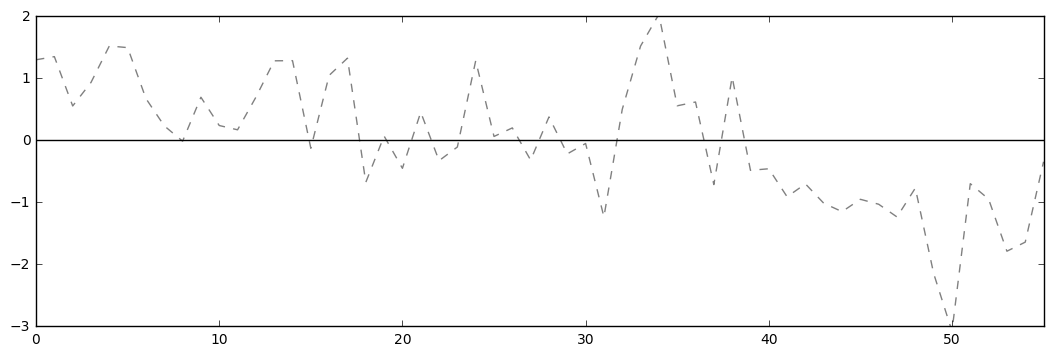

In [39]:
# Set all weights to 0
wgts = np.ones(datats.shape[0])   

# Apply the loess detrending operator:
datats_dt = loess_detrend(datats, \
                   np.array(range(0,datats.shape[0],1)), wgts, \
                   span=0.99, degree=2) 

# plot
fig2 = plt.figure(figsize=([13,4]),facecolor='white')        
plt.plot(datats-datats.mean(),color='grey',linestyle='--')
plt.plot(datats,color='b')
plt.plot([0,datats.shape[0]],[0,0],color='k')
plt.xlim(0,datats.shape[0]-1)
plt.ylim(-3,2)
plt.show()   


### Read PyClim lanczos documentation if needed:

In [15]:
filt.lanczos?

### 4. Apply lanczos filter to the detrended timeseries

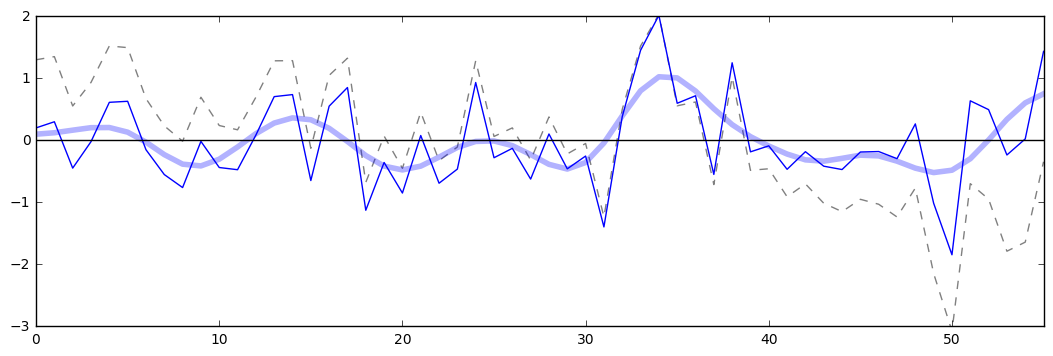

In [33]:
# Set filtering parameters:
# note1: for more info about the lanczos filter, see the documentation with filt.lanczos?


# sampling of the timeseries (in time units, e.g. yrs, months, etc)
frech=1   # ex: 1yr

# filtering cutoff (in time units)
TC=4   # ex: 5 yrs

# number of lanczos weights to use (should be at least 2* the filtering cutoff)
fc=TC*frech*2

# type of filter: 'lp' for low-pass
fity='lp'  
#fity='hp'

# compute the lanczos coefficients
lop10=filt.lanczos(fity,fc,1./fc)

# apply the filtering operator (note: remember to remove the time mean before filtering)
datats_dt_filt = datats_dt*0.
datats_dt_filt = lop10.do_filtering1d(datats_dt-datats_dt.mean(),output='same')
# Note: the option output='same' means that the output data  (i.e. filtered data)  has the same size as the input data. But keep in mind that 
# the lanczos filtering is such that fc/2 points are not fully filtered at both ends of the initial timeseries. Alternatively
# you could use the option output='valid' that would remove those end points from the output data.

# plot
fig3 = plt.figure(figsize=([13,4]),facecolor='white')        
plt.plot(datats-datats.mean(),color='grey',linestyle='--')
plt.plot(datats_dt,color='b')
plt.plot(datats_dt_filt,linewidth=4,alpha=0.3,color='b')
plt.plot([0,datats_dt.shape[0]],[0,0],color='k')
plt.xlim(0,datats.shape[0]-1)
plt.ylim(-3,2)
plt.show()   

#---- save plot
fig3.savefig("./test.pdf", facecolor=fig3.get_facecolor(), edgecolor='none')